<a href="https://colab.research.google.com/github/ArshT/Pytorch_Practice/blob/master/Pytorch_Simple_AE_Classification_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision.transforms import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5),(0.4))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,batch_size = 32,shuffle=True,num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset,batch_size = 32,shuffle=True,num_workers=2)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

device = torch.device("cuda:0" if USE_GPU else "cpu")

using device: cuda


In [4]:
class AutoEncoder(nn.Module):

  def __init__(self):
    super(AutoEncoder,self).__init__()

    self.conv1 = nn.Conv2d(1,16,3,(2,2),padding=(1,1))
    self.conv2 = nn.Conv2d(16,32,3,(2,2),padding=(1,1))
    self.conv3 = nn.Conv2d(32, 64, 7)

    self.t_conv1 = nn.ConvTranspose2d(64, 32, 7)
    self.t_conv2 = nn.ConvTranspose2d(32,16,3,stride=2,padding=1,output_padding=1)
    self.t_conv3 = nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)
  
  def forward(self,x):

    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.conv3(x)

    x = F.relu(self.t_conv1(x))
    x = F.relu(self.t_conv2(x))
    x = F.sigmoid(self.t_conv3(x))

    return x

autoencoder = AutoEncoder()
autoencoder = autoencoder.to('cuda')
print(autoencoder)



AutoEncoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  (t_conv1): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
  (t_conv2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv3): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)


In [5]:
criterion = nn.MSELoss()
optimizer_AE = optimizer = torch.optim.Adam(autoencoder.parameters(),lr=0.001, weight_decay=1e-5)

In [6]:
def val_loss(dataloader,criterion):

  I = 0
  total_loss = 0.0

  for data in dataloader:
    I += 1
    
    images,l = data
    images = images.to(device)

    out = autoencoder(images)

    loss = criterion(out,images)
    total_loss += loss

  avg_loss = total_loss / I

  return avg_loss

In [7]:
Check = []

for epoch in range(20):
  print("epoch",epoch+1)

  running_loss = 0.0
  for i,data in enumerate(trainloader,0):

    inputs,labels = data

    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer_AE.zero_grad()

    outputs = autoencoder(inputs)
    
    loss = criterion(outputs, inputs)

    loss.backward()

    optimizer_AE.step()

    running_loss += loss.item()
    
    
    if i % 300 == 299:    
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 300))
      running_loss = 0.0
  
  Check.append((epoch,inputs,outputs))
  v_loss = val_loss(testloader,criterion)

  print("Val_Loss:",v_loss)
  print("")

epoch 1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   300] loss: 1.534
[1,   600] loss: 1.450
[1,   900] loss: 1.450
[1,  1200] loss: 1.447
[1,  1500] loss: 1.446
[1,  1800] loss: 1.446
Val_Loss: tensor(1.4465, device='cuda:0', grad_fn=<DivBackward0>)

epoch 2
[2,   300] loss: 1.446
[2,   600] loss: 1.446
[2,   900] loss: 1.445
[2,  1200] loss: 1.446
[2,  1500] loss: 1.446
[2,  1800] loss: 1.446
Val_Loss: tensor(1.4464, device='cuda:0', grad_fn=<DivBackward0>)

epoch 3
[3,   300] loss: 1.430
[3,   600] loss: 1.368
[3,   900] loss: 1.345
[3,  1200] loss: 1.336
[3,  1500] loss: 1.329
[3,  1800] loss: 1.328
Val_Loss: tensor(1.3226, device='cuda:0', grad_fn=<DivBackward0>)

epoch 4
[4,   300] loss: 1.325
[4,   600] loss: 1.322
[4,   900] loss: 1.322
[4,  1200] loss: 1.320
[4,  1500] loss: 1.319
[4,  1800] loss: 1.318
Val_Loss: tensor(1.3154, device='cuda:0', grad_fn=<DivBackward0>)

epoch 5
[5,   300] loss: 1.318
[5,   600] loss: 1.317
[5,   900] loss: 1.317
[5,  1200] loss: 1.316
[5,  1500] loss: 1.316
[5,  1800] loss: 1.316
Val_Loss: 

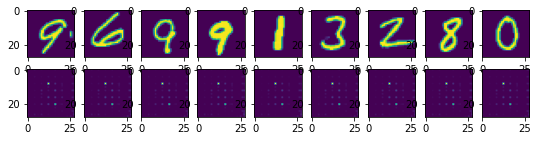

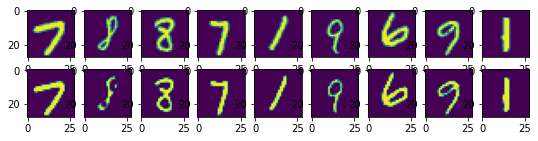

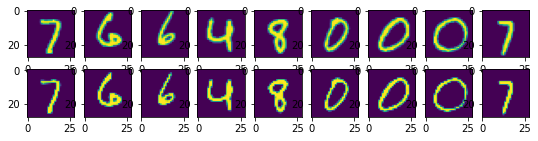

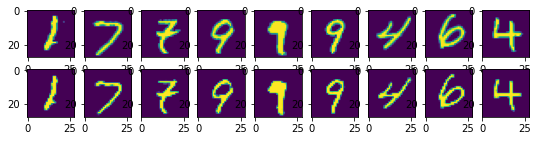

In [11]:
import matplotlib.pyplot as plt

for k in range(0, 20, 5):
    plt.figure(figsize=(9, 2))
    imgs = (Check[k][1].detach()).to('cpu').numpy()
    recon = (Check[k][2].detach()).to('cpu').numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


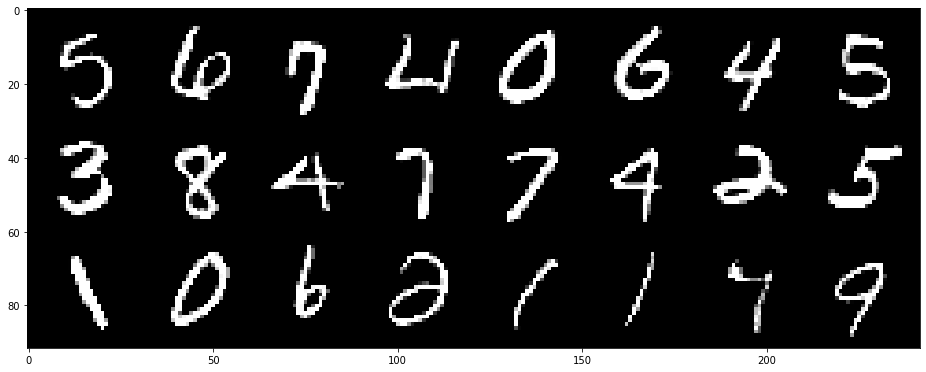

In [12]:
import numpy

samples, labels = iter(testloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


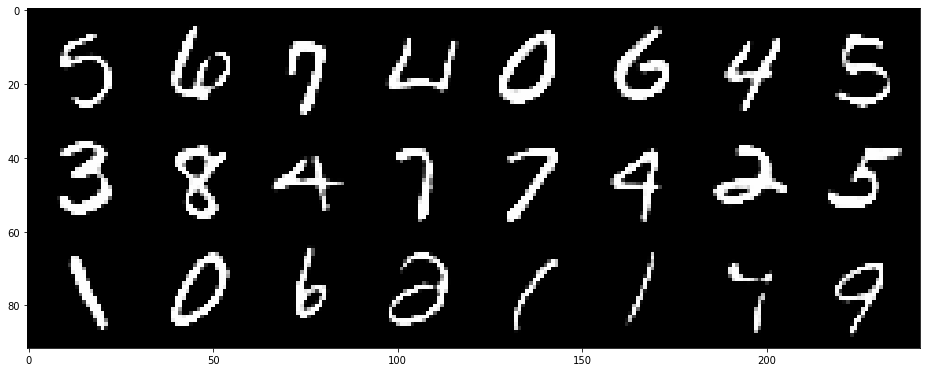

In [13]:
samples = samples.to('cuda')
Results = autoencoder(samples)
Resluts = Results.to('cpu')
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(Results[:24])
grid_imgs = grid_imgs.to('cpu')
np_grid_imgs = grid_imgs.detach().numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

In [17]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [18]:
PATH = '/content/gdrive/My Drive/Pytorch_Practice/MNIST_AE_Model-1.pt'
torch.save(autoencoder,PATH)

In [45]:
class Encoder(nn.Module):

  def __init__(self):
    super(Encoder,self).__init__()

    self.conv1 = nn.Conv2d(1,16,3,(2,2),padding=(1,1))
    self.conv2 = nn.Conv2d(16,32,3,(2,2),padding=(1,1))
    self.conv3 = nn.Conv2d(32, 64, 7)

  def forward(self,x):

    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.conv3(x)

    return x

encoder = Encoder()
encoder = encoder.to(device)
print(encoder)

Encoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
)


In [46]:
class Decoder(nn.Module):

  def __init__(self):
    super(Decoder,self).__init__()

    self.t_conv1 = nn.ConvTranspose2d(64, 32, 7)
    self.t_conv2 = nn.ConvTranspose2d(32,16,3,stride=2,padding=1,output_padding=1)
    self.t_conv3 = nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)


  def forward(self,x):

    x = F.relu(self.t_conv1(x))
    x = F.relu(self.t_conv2(x))
    x = F.sigmoid(self.t_conv3(x))

    return x

decoder = Decoder()
decoder = decoder.to(device)
print(decoder)

Decoder(
  (t_conv1): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
  (t_conv2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv3): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)


In [47]:
criterion_AE = nn.MSELoss()
optimizer_encoder = torch.optim.Adam(encoder.parameters(),lr=0.001, weight_decay=1e-5)
optimizer_decoder = torch.optim.Adam(decoder.parameters(),lr=0.001, weight_decay=1e-5)

In [48]:
def val_loss(dataloader,criterion):

  I = 0
  total_loss = 0.0

  for data in dataloader:
    I += 1
    
    images,l = data
    images = images.to(device)

    z_inter = encoder(images)
    out = decoder(z_inter)

    loss = criterion_AE(out,images)
    total_loss += loss

  avg_loss = total_loss / I

  return avg_loss

In [49]:
Check = []

for epoch in range(20):
  print("epoch",epoch+1)

  running_loss = 0.0
  for i,data in enumerate(trainloader,0):

    inputs,labels = data

    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer_encoder.zero_grad()
    optimizer_decoder.zero_grad()

    z = encoder(inputs)
    outputs = decoder(z)
    
    loss = criterion_AE(outputs, inputs)

    loss.backward()
    optimizer_encoder.step()
    optimizer_decoder.step()

    running_loss += loss.item()
    
    
    if i % 300 == 299:    
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 300))
      running_loss = 0.0
  
  Check.append((epoch,inputs,outputs))
  v_loss = val_loss(testloader,criterion)

  print("Val_Loss:",v_loss)
  print("")

epoch 1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   300] loss: 1.482
[1,   600] loss: 1.446
[1,   900] loss: 1.446
[1,  1200] loss: 1.446
[1,  1500] loss: 1.446
[1,  1800] loss: 1.446
Val_Loss: tensor(1.4465, device='cuda:0', grad_fn=<DivBackward0>)

epoch 2
[2,   300] loss: 1.446
[2,   600] loss: 1.445
[2,   900] loss: 1.446
[2,  1200] loss: 1.446
[2,  1500] loss: 1.446
[2,  1800] loss: 1.446
Val_Loss: tensor(1.4465, device='cuda:0', grad_fn=<DivBackward0>)

epoch 3
[3,   300] loss: 1.442
[3,   600] loss: 1.381
[3,   900] loss: 1.345
[3,  1200] loss: 1.334
[3,  1500] loss: 1.330
[3,  1800] loss: 1.326
Val_Loss: tensor(1.3212, device='cuda:0', grad_fn=<DivBackward0>)

epoch 4
[4,   300] loss: 1.323
[4,   600] loss: 1.322
[4,   900] loss: 1.321
[4,  1200] loss: 1.318
[4,  1500] loss: 1.319
[4,  1800] loss: 1.317
Val_Loss: tensor(1.3143, device='cuda:0', grad_fn=<DivBackward0>)

epoch 5
[5,   300] loss: 1.316
[5,   600] loss: 1.317
[5,   900] loss: 1.316
[5,  1200] loss: 1.315
[5,  1500] loss: 1.314
[5,  1800] loss: 1.316
Val_Loss: 

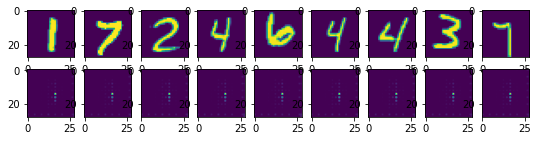

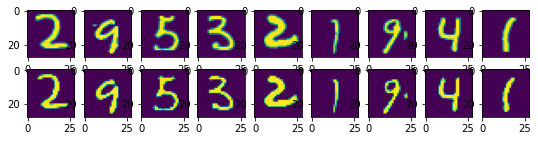

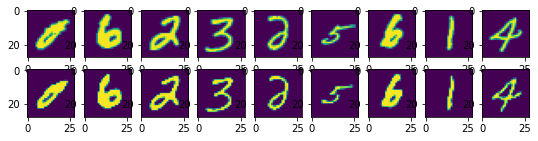

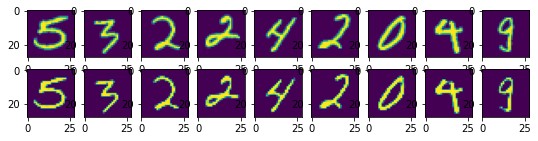

In [50]:
import matplotlib.pyplot as plt

for k in range(0, 20, 5):
    plt.figure(figsize=(9, 2))
    imgs = (Check[k][1].detach()).to('cpu').numpy()
    recon = (Check[k][2].detach()).to('cpu').numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


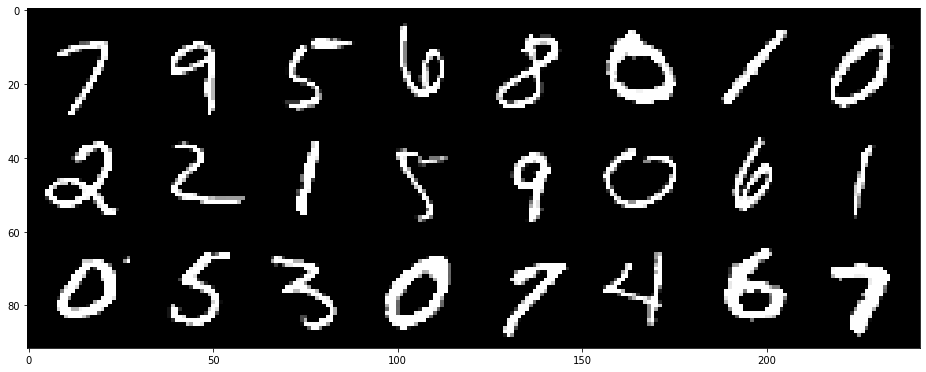

In [51]:
import numpy

samples, labels = iter(testloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


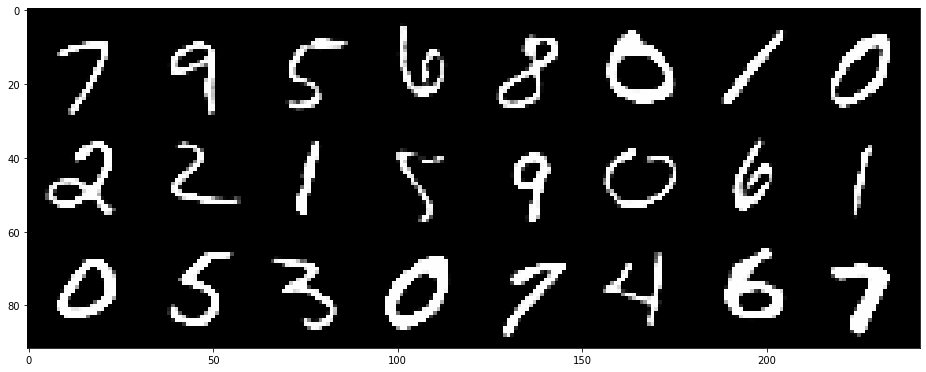

In [52]:
samples = samples.to('cuda')
Results = autoencoder(samples)
Resluts = Results.to('cpu')
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(Results[:24])
grid_imgs = grid_imgs.to('cpu')
np_grid_imgs = grid_imgs.detach().numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

In [53]:
PATH = '/content/gdrive/My Drive/Pytorch_Practice/MNIST_Encoder-1.pt'
torch.save(encoder,PATH)
PATH = '/content/gdrive/My Drive/Pytorch_Practice/MNIST_Decoder-1.pt'
torch.save(decoder,PATH)